Successfully loaded the data
Cluster Centers (Original Scale):
   Avg Bearer TP DL (kbps)  TCP DL Retrans. Vol (Bytes)
0              3800.642187                 1.167738e+06
1             62883.362083                 2.224066e+09
2             49136.770841                 1.780657e+07


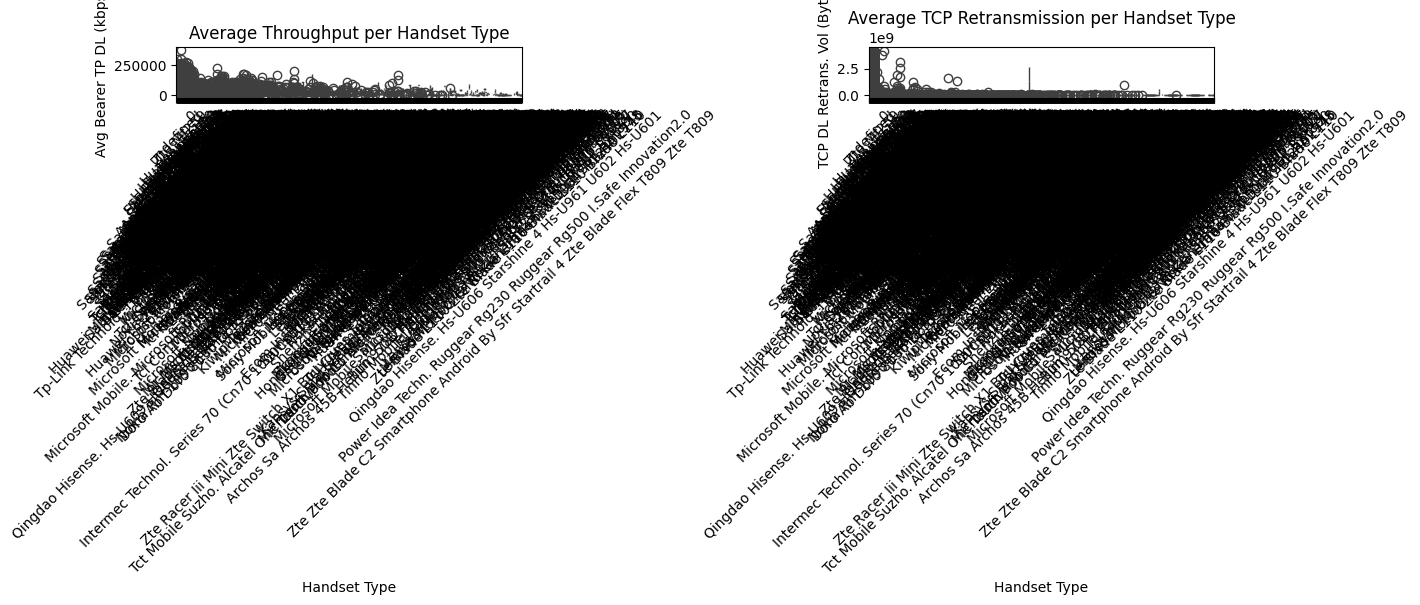

In [4]:
import sys
import os
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Append the script directory to sys.path
sys.path.append(os.path.abspath('../scripts'))

from telecom_analysis import load_data_using_sqlalchemy

# Load data from PostgreSQL
query = "SELECT * FROM xdr_data;"  # Adjust as needed
df = load_data_using_sqlalchemy(query)

if df is not None:
    print("Successfully loaded the data")
else:
    print("Failed to load data.")

# Task 3.1 - Aggregate per customer
def clean_and_aggregate(df):
    df.fillna(df.mean(numeric_only=True), inplace=True)  # Fill missing values with mean
    df.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace infinities with NaN
    df.fillna(df.mean(numeric_only=True), inplace=True)  # Fill NaNs with mean again

    grouped = df.groupby('IMEI').agg({
        'TCP DL Retrans. Vol (Bytes)': 'mean',
        'Avg RTT DL (ms)': 'mean',
        'Avg Bearer TP DL (kbps)': 'mean',
        'Handset Type': 'first'
    }).reset_index()

    return grouped

aggregated_df = clean_and_aggregate(df)

# Task 3.2 - Compute & list top, bottom, and most frequent values
def compute_statistics(df):
    top_10_tcp = df['TCP DL Retrans. Vol (Bytes)'].nlargest(10)
    bottom_10_tcp = df['TCP DL Retrans. Vol (Bytes)'].nsmallest(10)
    frequent_tcp = df['TCP DL Retrans. Vol (Bytes)'].mode().head(10)

    top_10_rtt = df['Avg RTT DL (ms)'].nlargest(10)
    bottom_10_rtt = df['Avg RTT DL (ms)'].nsmallest(10)
    frequent_rtt = df['Avg RTT DL (ms)'].mode().head(10)

    top_10_throughput = df['Avg Bearer TP DL (kbps)'].nlargest(10)
    bottom_10_throughput = df['Avg Bearer TP DL (kbps)'].nsmallest(10)
    frequent_throughput = df['Avg Bearer TP DL (kbps)'].mode().head(10)

    return {
        'top_10_tcp': top_10_tcp,
        'bottom_10_tcp': bottom_10_tcp,
        'frequent_tcp': frequent_tcp,
        'top_10_rtt': top_10_rtt,
        'bottom_10_rtt': bottom_10_rtt,
        'frequent_rtt': frequent_rtt,
        'top_10_throughput': top_10_throughput,
        'bottom_10_throughput': bottom_10_throughput,
        'frequent_throughput': frequent_throughput
    }

stats_summary = compute_statistics(df)

# Task 3.3 - Distribution of average throughput and TCP retransmission
def plot_distributions(df):
    plt.figure(figsize=(14, 6))

    # Throughput distribution
    plt.subplot(1, 2, 1)
    sns.boxplot(x='Handset Type', y='Avg Bearer TP DL (kbps)', data=df)
    plt.title('Average Throughput per Handset Type')
    plt.xticks(rotation=45)

    # TCP retransmission distribution
    plt.subplot(1, 2, 2)
    sns.boxplot(x='Handset Type', y='TCP DL Retrans. Vol (Bytes)', data=df)
    plt.title('Average TCP Retransmission per Handset Type')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

# Task 3.4 - K-Means Clustering
def perform_kmeans(df):
    features = df[['Avg Bearer TP DL (kbps)', 'TCP DL Retrans. Vol (Bytes)']].copy()
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    kmeans = KMeans(n_clusters=3, random_state=0)
    df['Cluster'] = kmeans.fit_predict(scaled_features)
    cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
    return df, cluster_centers

clustered_df, cluster_centers = perform_kmeans(aggregated_df)

# Display cluster information
print("Cluster Centers (Original Scale):")
print(pd.DataFrame(cluster_centers, columns=['Avg Bearer TP DL (kbps)', 'TCP DL Retrans. Vol (Bytes)']))

# Plotting the data
plot_distributions(df)

def plot_violin(df, top_n=10):
    # Get top N handset types
    top_handsets = df['Handset Type'].value_counts().head(top_n).index
    filtered_df = df[df['Handset Type'].isin(top_handsets)]

    plt.figure(figsize=(14, 6))

    # Violin plot for throughput distribution
    plt.subplot(1, 2, 1)
    sns.violinplot(x='Handset Type', y='Avg Bearer TP DL (kbps)', data=filtered_df)
    plt.title(f'Throughput Distribution for Top {top_n} Handset Types')
    plt.xticks(rotation=45)

    # Violin plot for TCP retransmission distribution
    plt.subplot(1, 2, 2)
    sns.violinplot(x='Handset Type', y='TCP DL Retrans. Vol (Bytes)', data=filtered_df)
    plt.title(f'TCP Retransmission Distribution for Top {top_n} Handset Types')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

plot_violin(df)

def plot_top_handset_types(df, top_n=10):
    # Get top N handset types by occurrence
    top_handsets = df['Handset Type'].value_counts().head(top_n).index
    filtered_df = df[df['Handset Type'].isin(top_handsets)]

    plt.figure(figsize=(14, 6))

    # Throughput bar plot for top handset types
    plt.subplot(1, 2, 1)
    sns.barplot(x='Handset Type', y='Avg Bearer TP DL (kbps)', data=filtered_df)
    plt.title(f'Average Throughput for Top {top_n} Handset Types')
    plt.xticks(rotation=45)

    # TCP retransmission bar plot for top handset types
    plt.subplot(1, 2, 2)
    sns.barplot(x='Handset Type', y='TCP DL Retrans. Vol (Bytes)', data=filtered_df)
    plt.title(f'Average TCP Retransmission for Top {top_n} Handset Types')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

plot_top_handset_types(df)
def plot_histograms(df):
    plt.figure(figsize=(14, 6))

    # Histogram for Throughput
    plt.subplot(1, 2, 1)
    sns.histplot(df['Avg Bearer TP DL (kbps)'], bins=30, kde=True)
    plt.title('Distribution of Average Throughput (kbps)')

    # Histogram for TCP Retransmission
    plt.subplot(1, 2, 2)
    sns.histplot(df['TCP DL Retrans. Vol (Bytes)'], bins=30, kde=True)
    plt.title('Distribution of TCP DL Retrans. Vol (Bytes)')

    plt.tight_layout()
    plt.show()

plot_histograms(df)



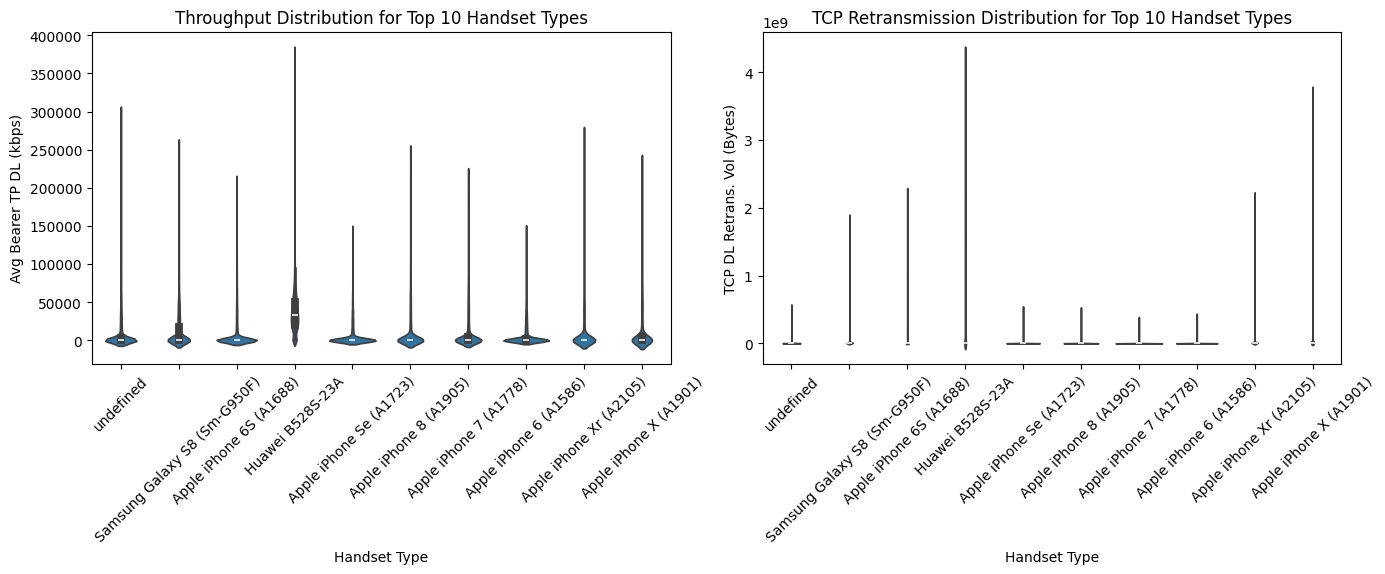

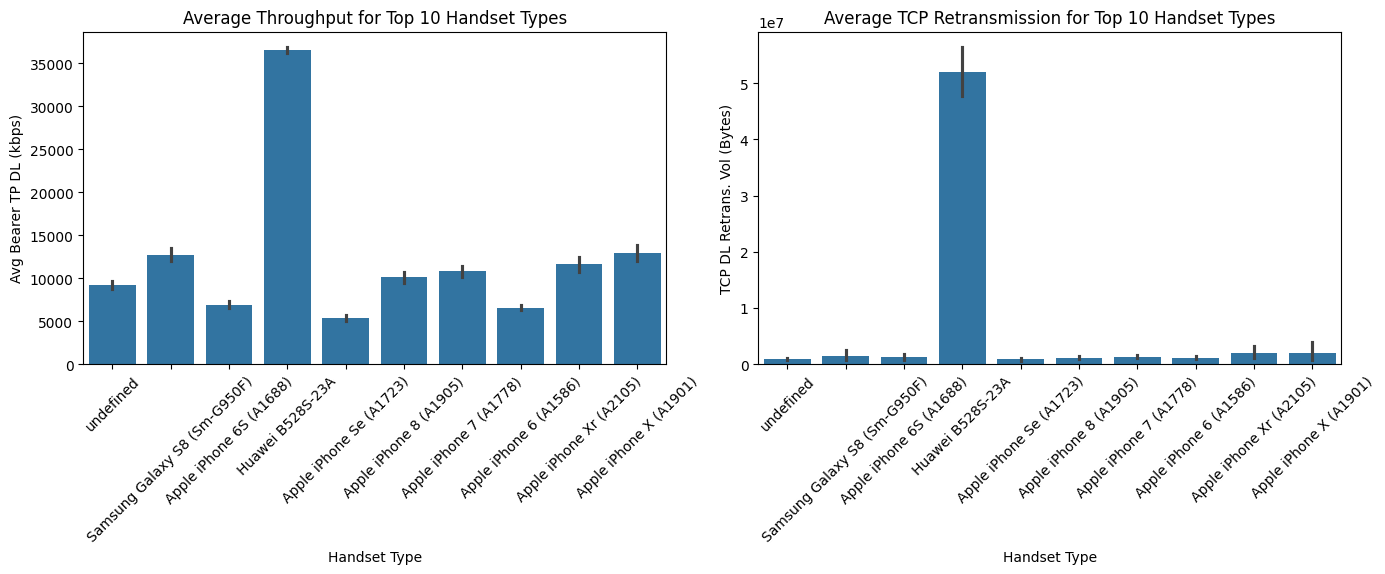

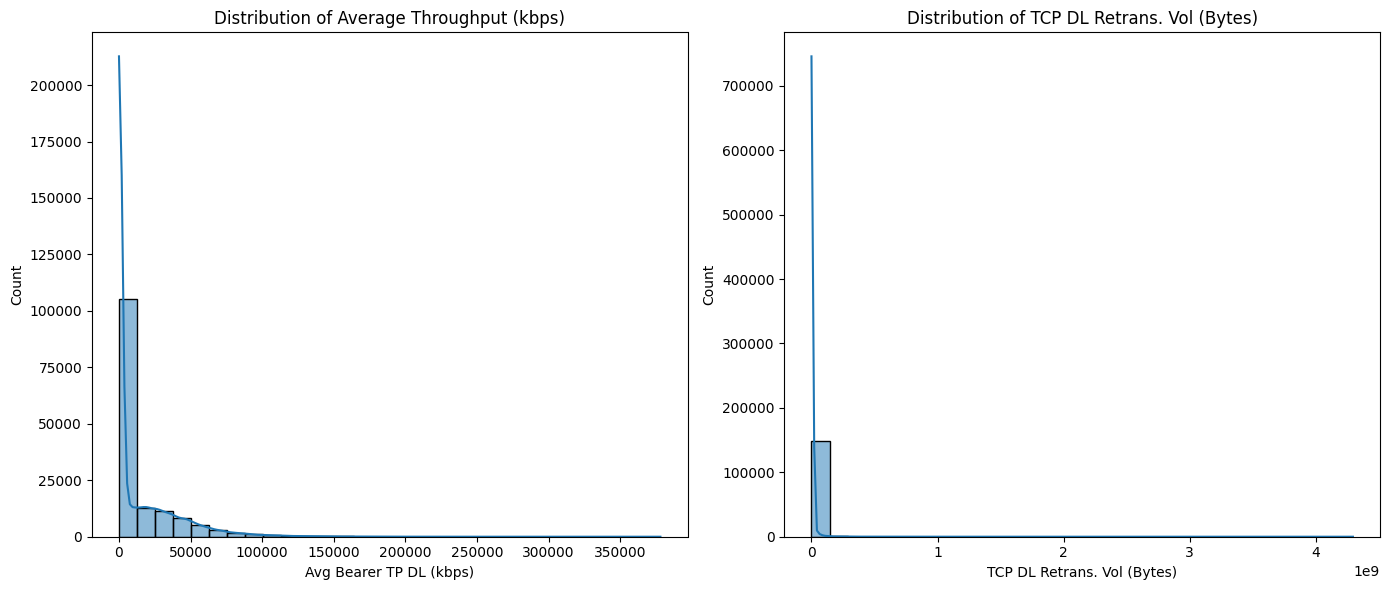

Successfully loaded the data

Top 10 TCP Retransmission Values:
73411     4.294426e+09
131110    4.291380e+09
30077     4.289877e+09
136245    4.289488e+09
149215    4.288060e+09
115116    4.275259e+09
35069     4.268432e+09
72422     4.259997e+09
54448     4.256650e+09
36641     4.254644e+09
Name: TCP DL Retrans. Vol (Bytes), dtype: float64

Bottom 10 TCP Retransmission Values:
1     0.0
3     0.0
5     0.0
8     0.0
9     0.0
11    0.0
13    0.0
17    0.0
18    0.0
23    0.0
Name: TCP DL Retrans. Vol (Bytes), dtype: float64

Most Frequent TCP Retransmission Values:
0    0.0
Name: TCP DL Retrans. Vol (Bytes), dtype: float64

Top 10 RTT Values:
25598     96923.0
25359     64640.0
13342     55811.0
1421      54847.0
18283     26971.0
18887     26250.0
146806    25873.0
76706     25602.0
92753     25374.0
96016     24733.0
Name: Avg RTT DL (ms), dtype: float64

Bottom 10 RTT Values:
1     0.0
5     0.0
9     0.0
13    0.0
33    0.0
34    0.0
37    0.0
41    0.0
64    0.0
66    0.0
Name: 

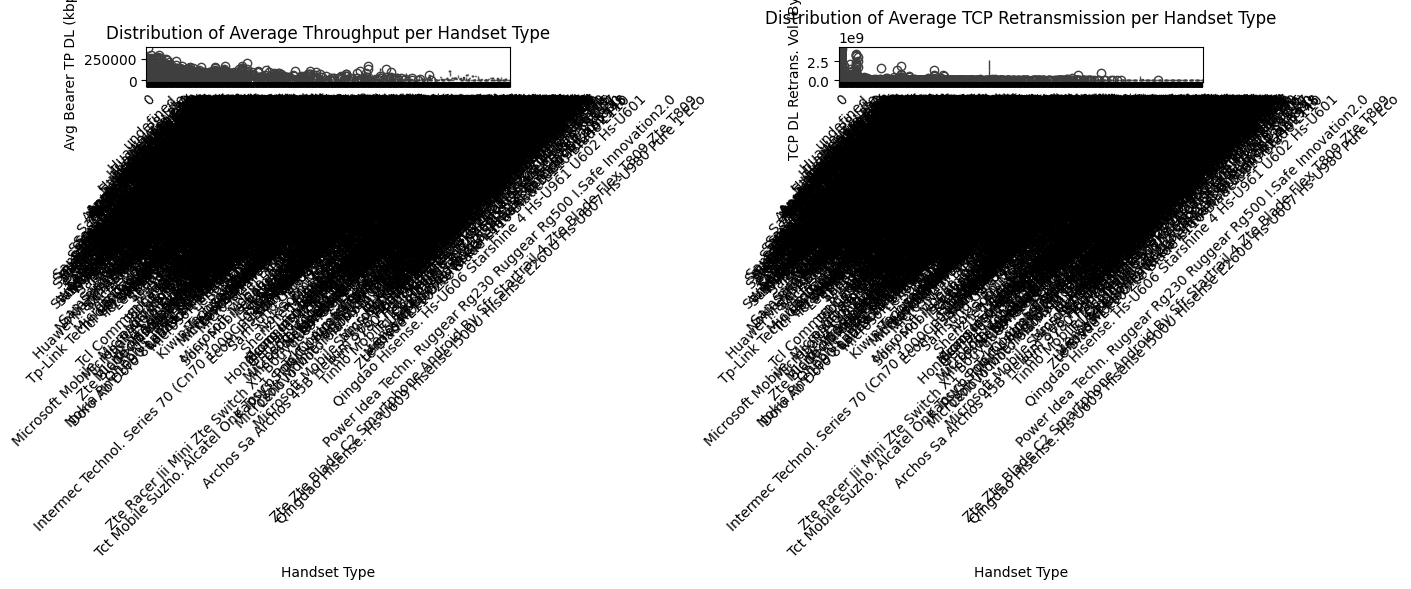

Aggregated Data by Handset Type:
                                           Handset Type  \
0                                                     0   
1                            A-Link Telecom I. Cubot A5   
2                     A-Link Telecom I. Cubot Note Plus   
3                        A-Link Telecom I. Cubot Note S   
4                          A-Link Telecom I. Cubot Nova   
...                                                 ...   
1392  Zte Zte Blade C2 Smartphone Android By Sfr Sta...   
1393                          Zyxel Communicat. Lte7460   
1394                          Zyxel Communicat. Sbg3600   
1395                    Zyxel Communicat. Zyxel Wah7706   
1396                                          undefined   

      Avg Bearer TP DL (kbps)  TCP DL Retrans. Vol (Bytes)  
0                10790.970280                 1.146738e+07  
1                23184.000000                 0.000000e+00  
2                 6527.000000                 6.023490e+05  
3             

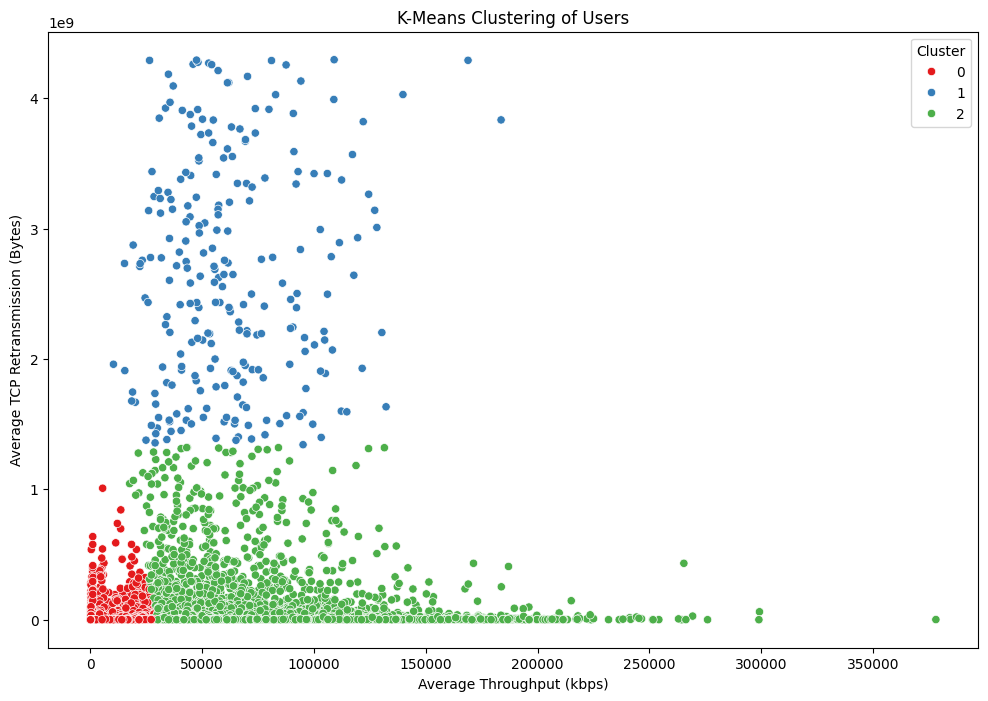

In [3]:
import sys
import os
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Append the script directory to sys.path
sys.path.append(os.path.abspath('../scripts'))

from telecom_analysis import load_data_using_sqlalchemy

# Load data from PostgreSQL
query = "SELECT * FROM xdr_data;"  # Adjust as needed
df = load_data_using_sqlalchemy(query)

if df is not None:
    print("Successfully loaded the data")
else:
    print("Failed to load data.")

# Task 3.1 - Aggregate per customer
def clean_and_aggregate(df):
    df.fillna({
        'TCP DL Retrans. Vol (Bytes)': df['TCP DL Retrans. Vol (Bytes)'].mean(),
        'Avg RTT DL (ms)': df['Avg RTT DL (ms)'].mean(),
        'Avg Bearer TP DL (kbps)': df['Avg Bearer TP DL (kbps)'].mean(),
        'Handset Type': df['Handset Type'].mode()[0]
    }, inplace=True)
    
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna({
        'TCP DL Retrans. Vol (Bytes)': df['TCP DL Retrans. Vol (Bytes)'].mean(),
        'Avg RTT DL (ms)': df['Avg RTT DL (ms)'].mean(),
        'Avg Bearer TP DL (kbps)': df['Avg Bearer TP DL (kbps)'].mean()
    }, inplace=True)
    
    aggregated = df.groupby('IMEI').agg({
        'TCP DL Retrans. Vol (Bytes)': 'mean',
        'Avg RTT DL (ms)': 'mean',
        'Avg Bearer TP DL (kbps)': 'mean',
        'Handset Type': 'first'
    }).reset_index()

    return aggregated

aggregated_df = clean_and_aggregate(df)

# Task 3.2 - Compute & list top, bottom, and most frequent values
def compute_statistics(df):
    top_10_tcp = df['TCP DL Retrans. Vol (Bytes)'].nlargest(10)
    bottom_10_tcp = df['TCP DL Retrans. Vol (Bytes)'].nsmallest(10)
    frequent_tcp = df['TCP DL Retrans. Vol (Bytes)'].mode()
    
    top_10_rtt = df['Avg RTT DL (ms)'].nlargest(10)
    bottom_10_rtt = df['Avg RTT DL (ms)'].nsmallest(10)
    frequent_rtt = df['Avg RTT DL (ms)'].mode()
    
    top_10_throughput = df['Avg Bearer TP DL (kbps)'].nlargest(10)
    bottom_10_throughput = df['Avg Bearer TP DL (kbps)'].nsmallest(10)
    frequent_throughput = df['Avg Bearer TP DL (kbps)'].mode()
    
    print("\nTop 10 TCP Retransmission Values:")
    print(top_10_tcp)
    
    print("\nBottom 10 TCP Retransmission Values:")
    print(bottom_10_tcp)
    
    print("\nMost Frequent TCP Retransmission Values:")
    print(frequent_tcp)
    
    print("\nTop 10 RTT Values:")
    print(top_10_rtt)
    
    print("\nBottom 10 RTT Values:")
    print(bottom_10_rtt)
    
    print("\nMost Frequent RTT Values:")
    print(frequent_rtt)
    
    print("\nTop 10 Throughput Values:")
    print(top_10_throughput)
    
    print("\nBottom 10 Throughput Values:")
    print(bottom_10_throughput)
    
    print("\nMost Frequent Throughput Values:")
    print(frequent_throughput)
    
    return {
        'top_10_tcp': top_10_tcp,
        'bottom_10_tcp': bottom_10_tcp,
        'frequent_tcp': frequent_tcp,
        'top_10_rtt': top_10_rtt,
        'bottom_10_rtt': bottom_10_rtt,
        'frequent_rtt': frequent_rtt,
        'top_10_throughput': top_10_throughput,
        'bottom_10_throughput': bottom_10_throughput,
        'frequent_throughput': frequent_throughput
    }

stats_summary = compute_statistics(df)

# Task 3.3 - Distribution of average throughput and TCP retransmission
def compute_and_plot_distributions(df):
    aggregated_data = df.groupby('Handset Type').agg({
        'Avg Bearer TP DL (kbps)': 'mean',
        'TCP DL Retrans. Vol (Bytes)': 'mean'
    }).reset_index()
    
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.boxplot(x='Handset Type', y='Avg Bearer TP DL (kbps)', data=df)
    plt.title('Distribution of Average Throughput per Handset Type')
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    sns.boxplot(x='Handset Type', y='TCP DL Retrans. Vol (Bytes)', data=df)
    plt.title('Distribution of Average TCP Retransmission per Handset Type')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()
    
    print("Aggregated Data by Handset Type:")
    print(aggregated_data)

compute_and_plot_distributions(df)

# Task 3.4 - K-Means Clustering
def perform_kmeans_clustering(df, n_clusters=3):
    features = df[['Avg Bearer TP DL (kbps)', 'TCP DL Retrans. Vol (Bytes)', 'Avg RTT DL (ms)']].copy()
    features.fillna(features.mean(), inplace=True)
    
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
    df['Cluster'] = kmeans.fit_predict(scaled_features)
    
    cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
    cluster_centers_df = pd.DataFrame(cluster_centers, columns=['Avg Bearer TP DL (kbps)', 'TCP DL Retrans. Vol (Bytes)', 'Avg RTT DL (ms)'])
    
    print("Cluster Centers (Original Scale):")
    print(cluster_centers_df)
    
    return df

def describe_clusters(df):
    cluster_description = df.groupby('Cluster').agg({
        'Avg Bearer TP DL (kbps)': ['mean', 'std'],
        'TCP DL Retrans. Vol (Bytes)': ['mean', 'std'],
        'Avg RTT DL (ms)': ['mean', 'std'],
        'IMEI': 'count'
    }).reset_index()
    
    print("\nCluster Descriptions:")
    print(cluster_description)

    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='Avg Bearer TP DL (kbps)', y='TCP DL Retrans. Vol (Bytes)', hue='Cluster', data=df, palette='Set1')
    plt.title('K-Means Clustering of Users')
    plt.xlabel('Average Throughput (kbps)')
    plt.ylabel('Average TCP Retransmission (Bytes)')
    plt.legend(title='Cluster')
    plt.show()

clustered_df = perform_kmeans_clustering(df)
describe_clusters(clustered_df)
